In [1]:
using Plots
using Optim
using NLopt
using ForwardDiff

# Numerical Optimization

The general problem we consider is how to find the maximizing element
$\hat{\theta}$ (a $K$ -vector) of a function $s(\theta).$ This
function may not be continuous, and it may not be differentiable.
Even if it is twice continuously differentiable, it may not be globally
concave, so [local maxima, minima](https://en.wikipedia.org/wiki/Maxima_and_minima)
and [saddlepoints](https://en.wikipedia.org/wiki/Saddle_point)
may all exist. Supposing $s(\theta)$ were a quadratic function of
$\theta,$ e.g., 
$$
s(\theta)=a+b^{\prime}\theta+\frac{1}{2}\theta^{\prime}C\theta,
$$
 the first order conditions would be linear:

$$
D_{\theta}s(\theta)=b+C\theta
$$
 so the maximizing (minimizing)\ element would be $\hat{\theta}=-C^{-1}b.$
This is the sort of problem we have with linear models estimated by
OLS. It's also the case for feasible GLS, since conditional on the
estimate of the varcov matrix, we have a quadratic objective function
in the remaining parameters. 

More general problems will not have linear f.o.c., and we will not
be able to solve for the maximizer analytically. This is when we need
a numeric optimization method.

## Search 

The idea is to create a grid over the parameter space and evaluate
the function at each point on the grid. Select the best point. Then
refine the grid in the neighborhood of the best point, and continue
until the accuracy is ''good enough''. One has to be careful that the grid is fine enough in relationship
to the irregularity of the function to ensure that sharp peaks are
not missed entirely.

To check $q$ values in each dimension of a $K$ dimensional parameter
space, we need to check $q^{K}$ points. For example, if $q=100$
and $K=10,$ there would be $100^{10}$ points to check. If 1000 points
can be checked in a second, it would take $3.\,171\times10^{9}$ years
to perform the calculations, which is approximately 2/3 the age of
the earth. The search method is a very reasonable choice if $K$ is
small, but it quickly becomes infeasible if $K$ is moderate or large. 

In [2]:
pi/2.0

1.5707963267948966

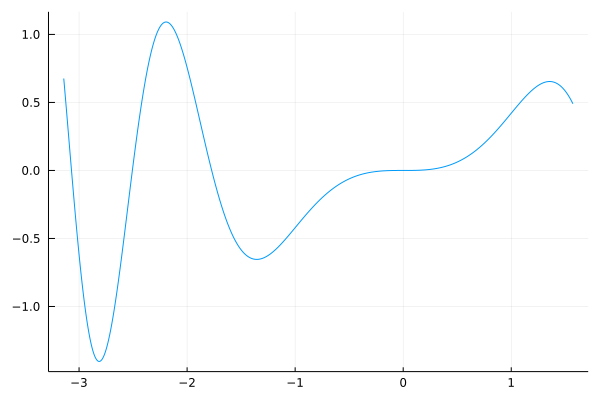

In [3]:
    # plot the line
    x = range(-pi,stop=pi/2.0,length=1000)
    obj = theta-> 0.5*theta*sin(theta^2.0)
    y = obj.(x)
    plot(x, y, legend=false)

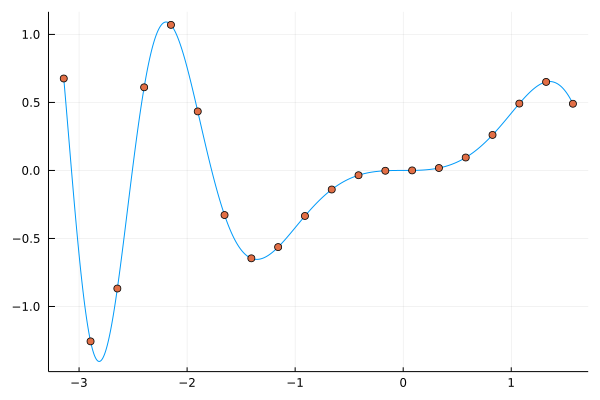

In [4]:
points=20 
    # plot the grid points
    x = range(-pi,stop=pi/2.0,length=points)
    y = obj.(x)
    scatter!(x, y)

In [5]:
argmin(y)

2

In [6]:
function GridExample(points)
    # plot the line
    x = range(-pi,stop=pi/2.0,length=1000)
    obj = theta-> 0.5*theta*sin(theta^2.0)
    y = obj.(x)
    plot(x, y, legend=false)
    # plot the grid points
    x = range(-pi,stop=pi/2.0,length=points)
    y = obj.(x)
    scatter!(x, y)
    # plot the best point found
    return scatter!([x[argmin(y)]], [y[argmin(y)]], markersize=10)
end

GridExample (generic function with 1 method)

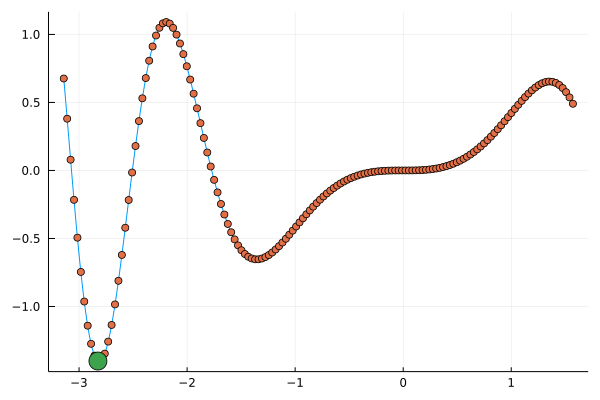

In [7]:
GridExample(150)

## Derivative-based methods
*In the following, the superscript $k$ is used as the index
of the iterations of a given method. It is not an exponent, and it
is not the dimension of the parameter vector.

Reference: https://www.youtube.com/watch?v=N_ZRcLheNv0 

We assume that the objective function is at least one time differentiable.
Otherwise, these methods are not applicable, obviously. Derivative-based
methods are defined by
1. the method for choosing the initial value, $\theta^{1}$
2. the iteration method for choosing $\theta^{k+1}$ given that we're at $\theta^{k}$ at iteration $k$ (based upon derivatives)
3. the stopping criterion. 

The iteration method can be broken into two problems: choosing the
stepsize $a^{k}$ (a scalar) and choosing the direction of movement,
$d^{k},$ which is of the same dimension of $\theta,$ so that 
$$
\theta^{(k+1)}=\theta^{(k)}+a^{k}d^{k}.
$$

A locally increasing direction of search $d$ is a
direction such that 
$$
\frac{\partial s(\theta+ad)}{\partial a}>0.
$$
 That is, if we go in direction $d$, we will improve on the objective
function, at least if we don't go too far.

As long as the gradient at $\theta^{k}$ is not zero, there exist
increasing directions, and they can all be represented as $Q^{k}g(\theta^{k})$
where $Q^{k}$ is a symmetric pd matrix and $g\left(\theta\right)=D_{\theta}s(\theta)$
is the gradient at $\theta$. To see this, take a Taylor's series
expansion around $a^{0}=0$
$$
\begin{eqnarray*}
s(\theta+ad) & = & s(\theta+0d)+\left(a-0\right)g(\theta+0d)^{\prime}d+o(1)\\
 & = & s(\theta)+ag(\theta)^{\prime}d+o(1)
\end{eqnarray*}
$$
For small enough $a$ the $o(1)$ term can be ignored. If $d$ is
to be an increasing direction, we need $g(\theta)^{\prime}d>0.$ Defining
$d=Qg(\theta),$ where $Q$ is positive definite, we guarantee that
$$
g(\theta)^{\prime}d=g(\theta)^{\prime}Qg(\theta)>0
$$
 unless $g(\theta)=0.$ Every increasing direction can be represented
in this way (p.d. matrices are those such that the angle between $g$
and $Qg(\theta)$ is less than 90 degrees).

With this, the iteration rule becomes 
$$
\theta^{(k+1)}=\theta^{(k)}+a^{k}Q^{k}g(\theta^{k})
$$

and we keep going until the gradient becomes zero, so that there is
no increasing direction. The problem is now how to choose $a$
and $Q.$
- Conditional on $Q$, choosing $a$ is fairly straightforward.
A simple line (1 dimensional grid) search is an attractive possibility,
since $a$ is a scalar. But there are other methods that may be better
(bisection, golden, etc.).
- The remaining problem is how to choose $Q.$
- Note also that this gives no guarantees to find a global maximum.


### Steepest Ascent

Reference: https://www.youtube.com/watch?v=TEB2z7ZlRAw

Steepest ascent (descent if we're minimizing) just sets $Q$ to an
identity matrix, since the gradient provides the direction of maximum
rate of increase of the objective function.
- Advantages: fast - doesn't require anything more than first derivatives.
- Disadvantages: This doesn't always work too well however: see the
[Rosenbrock, or ''banana'' function](http://en.wikipedia.org/wiki/Rosenbrock_function)

### Newton's Method

Reference: https://www.youtube.com/watch?v=W7S94pq5Xuo

Newton's method uses information about the slope and curvature of
the objective function to determine which direction and how far to
move from an initial point. Supposing we're trying to maximize $s_{n}(\theta).$
Take a second order Taylor's series approximation of $s_{n}(\theta)$
about $\theta^{k}$ (an initial guess). 
$$
s_{n}(\theta)\approx s_{n}(\theta^{k})+g(\theta^{k})^{\prime}\left(\theta-\theta^{k}\right)+1/2\left(\theta-\theta^{k}\right)^{\prime}H(\theta^{k})\left(\theta-\theta^{k}\right)
$$
($g$ is the gradient vector and $H$ is the Hessian matrix). To attempt
to maximize $s_{n}(\theta),$ we can maximize the portion of the right-hand
side that depends on $\theta$, we can maximize 
$$
\tilde{s}(\theta)=g(\theta^{k})^{\prime}\theta+1/2\left(\theta-\theta^{k}\right)^{\prime}H(\theta^{k})\left(\theta-\theta^{k}\right)
$$
 with respect to $\theta.$ This is a much easier problem, since it
is a quadratic function in $\theta,$ so it has linear first order
conditions. These are

$$
D_{\theta}\tilde{s}(\theta)=g(\theta^{k})+H(\theta^{k})\left(\theta-\theta^{k}\right)
$$
 So the solution for the next round estimate is 
$$
\theta^{k+1}=\theta^{k}-H(\theta^{k})^{-1}g(\theta^{k})
$$

However, it's good to include a stepsize, since the approximation
to $s_{n}(\theta)$ may be bad far away from the maximizer $\hat{\theta},$
so the actual iteration formula is 
$$
\theta^{k+1}=\theta^{k}-a^{k}H(\theta^{k})^{-1}g(\theta^{k})
$$
- A potential problem is that the Hessian may not be negative definite
when we're far from the maximizing point. So $-H(\theta^{k})^{-1}$
may not be positive definite, and $-H(\theta^{k})^{-1}g(\theta^{k})$
may not define an increasing direction of search. This can happen
when the objective function has flat regions, in which case the Hessian
matrix is very ill-conditioned (e.g., is nearly singular), or when
we're in the vicinity of a local minimum, $H(\theta^{k})$ is positive
definite, and our direction is a decreasing direction of search.
Matrix inverses by computers are subject to large errors when the
matrix is ill-conditioned. Also, we certainly don't want to go in
the direction of a minimum when we're maximizing. To solve this problem,
Quasi-Newton methods simply add a positive definite component
to $H(\theta)$ to ensure that the resulting matrix is positive definite,
e.g., $Q=-H(\theta)+b\mathbf{I},$ where $b$ is chosen large
enough so that $Q$ is well-conditioned and positive definite. This
has the benefit that improvement in the objective function is guaranteed.
- Another variation of quasi-Newton methods is to approximate the Hessian
by using successive gradient evaluations. This avoids actual calculation
of the Hessian, which is an order of magnitude (in the dimension of
the parameter vector) more costly than calculation of the gradient.
They can be done to ensure that the approximation is p.d. DFP and
BFGS are two well-known examples

In [8]:
rosenbrock(x) =  (1.0 - x[1])^2 + 100.0 * (x[2] - x[1]^2)^2
result = Optim.optimize(rosenbrock, zeros(2), Newton())

 * Status: success

 * Candidate solution
    Final objective value:     5.378326e-17

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 3.08e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.08e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.01e-17 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.59e-01 ≰ 0.0e+00
    |g(x)|                 = 3.42e-13 ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    14
    f(x) calls:    44
    ∇f(x) calls:   44
    ∇²f(x) calls:  14


### Stopping Criteria

The last thing we need is to decide when to stop. A digital computer
is subject to limited machine precision and round-off errors. For
these reasons, it is unreasonable to hope that a program can **exactly**
find the point that maximizes a function. We need to define acceptable
tolerances. Some stopping criteria are:
- Negligible change in parameters: 
$4
|\theta_{j}^{k}-\theta_{j}^{k-1}|<\varepsilon_{1},\forall j
$4
- Negligible relative change: 
$$
|\frac{\theta_{j}^{k}-\theta_{j}^{k-1}}{\theta_{j}^{k-1}}|<\varepsilon_{2},\forall j
$$
- Negligible change of function: 
$$
|s(\theta^{k})-s(\theta^{k-1})|<\varepsilon_{3}
$$
- Gradient negligibly different from zero: 
$$
|g_{j}(\theta^{k})|<\varepsilon_{4},\forall j
$$
- Or, even better, check all of these.
- Also, if we're maximizing, it's good to check that the last round
(real, not approximate) Hessian is negative definite. 



###  Starting Values
The Newton-Raphson and related algorithms work well if the objective
function is concave (when maximizing), but not so well if there are
convex regions and local minima or multiple local maxima. The algorithm
may converge to a local minimum or to a local maximum that is not
optimal. The algorithm may also have difficulties converging at all.
- The usual way to ENSURE that a global maximum has been found is to use many different starting values, and choose the solution
that returns the highest objective function value. **THIS IS IMPORTANT IN PRACTICE** 
- an alternative is to use a global optimization algorithm, e.g., simulated
annealing or others, which may or may not be gradient based.


### Calculating Derivatives

The Newton-Raphson algorithm requires first and second derivatives.
It is often difficult to calculate derivatives (especially the Hessian)
analytically if the function $s_{n}(\cdot)$ is complicated. Possible
solutions are to calculate derivatives numerically, or to use programs
such as MuPAD or Mathematica to calculate analytic derivatives. 

Numeric derivatives are less accurate than analytic derivatives, and
are usually more costly to evaluate. Both factors usually cause optimization
programs to be less successful when numeric derivatives are used. 
- One advantage of numeric derivatives is that you don't have to worry
about having made an error in calculating the analytic derivative.
When programming analytic derivatives it's a good idea to check that
they are correct by using numeric derivatives. This is a lesson I
learned the hard way when writing my thesis.
- there are also methods for automatic differentiation. This
will probably become important in the future, but existing econometric
software makes little use of it.

## Julia Code: Unconstraint Optimization

$${\hat{x_1},\hat{x_2}} = \arg \min_{x} (1-x_1)^2 + 100(x_2 - x_1^2)^2$$

In [9]:
"""
    xopt, fopt, converged = fminunc(obj, startval)

Minimize the function obj, starting at startval.

fminunc() with no arguments will run an example, execute edit(fminunc,()) to see the code.
fminunc() uses NLopt.jl  to do the actual minimization.

"""
function fminunc(obj, x; tol = 1e-10)
    results = Optim.optimize(obj, x, LBFGS(), 
                            Optim.Options(
                            g_tol = tol,
                            x_tol=tol,
                            f_tol=tol))
    return results.minimizer, results.minimum, Optim.converged(results)
    #xopt, objvalue, flag = fmincon(obj, x, tol=tol)
    #return xopt, objvalue, flag
end

fminunc

In [10]:
fminunc(rosenbrock,zeros(2);tol=1e-8)

([0.9999999926662504, 0.9999999853325008], 5.378388330692143e-17, true)

## Julia Code: Constraint Optimization

$${\hat{x_1},\hat{x_2}} = \arg \min_{x} (1-x_1)^2 + 100(x_2 - x_1^2)^2$$
such that
$$Rx = r$$

In [11]:
"""
    xopt, fopt, converged = fmincon(obj, startval)

Minimize the function obj, starting at startval.

fminunc() with no arguments will run an example, execute edit(fminunc,()) to see the code.
fminunc() uses NLopt.jl to do the actual minimization.

"""
function fmincon(obj, startval, R=[], r=[], lb=[], ub=[]; tol = 1e-10, iterlim=0)
    # the objective is an anonymous function
    function objective_function(x::Vector{Float64}, grad::Vector{Float64})
        obj_func_value = obj(x)[1,1]
        return(obj_func_value)
    end
    # impose the linear restrictions
    function constraint_function(x::Vector, grad::Vector, R, r)
        result = R*x .- r
        return result[1,1]
    end
    opt = Opt(:LN_COBYLA, size(startval,1))
    min_objective!(opt, objective_function)
    # impose lower and/or upper bounds
    if lb != [] lower_bounds!(opt, lb) end
    if ub != [] upper_bounds!(opt, ub) end
    # impose linear restrictions, by looping over the rows
    if R != []
        for i = 1:size(R,1)
            equality_constraint!(opt, (theta, g) -> constraint_function(theta, g, R[i:i,:], r[i]), tol)
        end
    end    
    xtol_rel!(opt, tol)
    ftol_rel!(opt, tol)
    maxeval!(opt, iterlim)
    (objvalue, xopt, flag) = NLopt.optimize(opt, startval)
    return xopt, objvalue, flag
end


fmincon

- Tutorial for NLopt for many languages: https://nlopt.readthedocs.io/en/latest/NLopt_Tutorial/
- Tutorial for NLopt module for Julia: https://github.com/JuliaOpt/NLopt.jl

In [12]:
obj = x -> x'x
startval = [2.0, 2.0]
# sum of params should be 1
R = [1.0 1.0]
r = 1.0

1.0

In [13]:
thetahat, q_thetahat, convergence = fmincon(obj, startval, R, r)

([0.49999750305193874, 0.5000024969480613], 0.5000000000124696, :FTOL_REACHED)

In [14]:
R

1×2 Array{Float64,2}:
 1.0  1.0

In [15]:
thetahat

2-element Array{Float64,1}:
 0.49999750305193874
 0.5000024969480613

In [16]:
typeof((R*thetahat .- r)[1,1])

Float64

In [17]:
typeof((R*thetahat .- r))

Array{Float64,1}

In [18]:
fmincon(rosenbrock,zeros(2))

([0.999999880198371, 0.999999759705828], 1.4400168508129254e-14, :XTOL_REACHED)